# This is the codebase for VASARI-auto

###	vasari-auto.py | a pipeline for automated VASARI characterisation of glioma.

###	Copyright 2024 James Ruffle, High-Dimensional Neurology, UCL Queen Square Institute of Neurology.

###	This program is licensed under the APACHE 2.0 license.

###	This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  

###	See the License for more details.

###	This code is part of the repository https://github.com/james-ruffle/vasari-auto

###	Correspondence to Dr James K Ruffle by email: j.ruffle@ucl.ac.uk

In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/opt/homebrew/opt/python@3.11/bin/python3.11
3.11.4 (main, Jun 15 2023, 07:55:38) [Clang 14.0.3 (clang-1403.0.22.14.1)]
sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)


In [2]:
#Import packages
import glob
import numpy as np
import os
import pandas as pd
import shutil
import errno
import subprocess
from datetime import datetime
from tqdm import tqdm
import argparse
import nibabel as nib
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import seaborn as sns
from sklearn.metrics import *
import time
from skimage.morphology import skeletonize
import matplotlib.ticker as mticker
from scipy import stats
pd.set_option('display.max_rows', 500)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
desktop = False
 
if desktop:
    user = 'jamesruffle'
if not desktop:
    user = 'jruffle'

In [4]:
#where annotated nifti segmentations will be pulled from
seg_path = '/Users/'+str(user)+'/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/VASARI/data/RADIOLOGISTS/IMAGES/'

#atlas paths
atlases = '/Users/'+str(user)+'/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/VASARI/TUTORIAL/atlas_masks/'

#consultant neuroradiologist validation
df = pd.read_excel('/Users/'+str(user)+'/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/VASARI/data/labelled_data/merged_radiologist_labelled_data.xlsx',index_col=0)
for i, row in df.iterrows():
    if 'UCSF' in df.loc[i,'filename']:
        padded_num = row['filename'].split('-')[-1].zfill(4)
        df.loc[i,'filename'] = 'UCSF-PDGM-'+str(padded_num)

#segmentations to evaluate
model_prediction = '/Users/'+str(user)+'/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/model_prediction/'
neurorad_hand_label = '/Users/'+str(user)+'/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/neurorad_hand_label/'

neurorad_hand_label_subs = df['filename'].values

figures_out = '/Users/'+str(user)+'/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/VASARI/Results/figs_output/'

print("Number of lesions: "+str(len(neurorad_hand_label_subs)))
print('')
print('#unique lesions: '+str(len(df['filename'].unique())))
print('')
print('#number double reported for inter-rater variability: '+str(len(neurorad_hand_label_subs)-len(df['filename'].unique())))

Number of lesions: 100

#unique lesions: 87

#number double reported for inter-rater variability: 13


In [5]:
time_str = '8m 43s'
time_str

def time_string_to_seconds(time_str):
    minutes, seconds = int(time_str.split('m')[0]), int(time_str.split('m')[-1].split('s')[0])
    total_seconds = minutes * 60 + seconds
    return total_seconds

for i, row in tqdm(df.iterrows(),total=len(df)):
    df.loc[i,'time_taken_seconds']=time_string_to_seconds(row['time_taken_seconds'])

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 17864.07it/s]


In [6]:
##derive anatomy masks - this is for automated location (F1)
brainstem = atlases+'brainstem.nii.gz'
brainstem = nib.load(brainstem)
brainstem_array = np.asanyarray(brainstem.dataobj)
brainstem_vol = np.sum(brainstem_array)

frontal_lobe = atlases+'frontal_lobe.nii.gz'
frontal_lobe = nib.load(frontal_lobe)
frontal_lobe_array = np.asanyarray(frontal_lobe.dataobj)
frontal_lobe_vol = np.sum(frontal_lobe_array)

insula = atlases+'insula.nii.gz'
insula = nib.load(insula)
insula_array = np.asanyarray(insula.dataobj)
insula_vol = np.sum(insula_array)

occipital = atlases+'occipital.nii.gz'
occipital = nib.load(occipital)
occipital_array = np.asanyarray(occipital.dataobj)
occipital_vol = np.sum(occipital_array)

parietal = atlases+'parietal.nii.gz'
parietal = nib.load(parietal)
parietal_array = np.asanyarray(parietal.dataobj)
parietal_vol = np.sum(parietal_array)

temporal = atlases+'temporal.nii.gz'
temporal = nib.load(temporal)
temporal_array = np.asanyarray(temporal.dataobj)
temporal_vol = np.sum(temporal_array)

thalamus = atlases+'thalamus.nii.gz'
thalamus = nib.load(thalamus)
thalamus_array = np.asanyarray(thalamus.dataobj)
thalamus_vol = np.sum(thalamus_array)

corpus_callosum = atlases+'corpus_callosum.nii.gz'
corpus_callosum = nib.load(corpus_callosum)
corpus_callosum_array = np.asanyarray(corpus_callosum.dataobj)
corpus_callosum_vol = np.sum(corpus_callosum_array)

ventricles = atlases+'ventricles.nii.gz'
ventricles = nib.load(ventricles)
ventricles_array = np.asanyarray(ventricles.dataobj)
ventricles_vol = np.sum(ventricles_array)

internal_capsule = atlases+'internal_capsule.nii.gz'
internal_capsule = nib.load(internal_capsule)
internal_capsule_array = np.asanyarray(internal_capsule.dataobj)
internal_capsule_vol = np.sum(internal_capsule_array)

cortex = atlases+'cortex.nii.gz'
cortex = nib.load(cortex)
cortex_array = np.asanyarray(cortex.dataobj)
cortex_vol = np.sum(cortex_array)

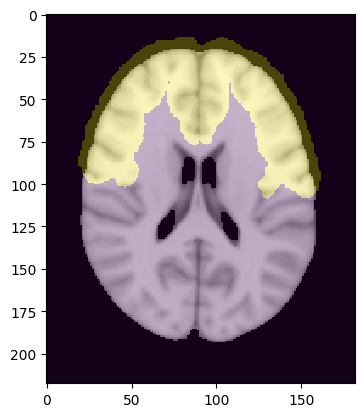

In [7]:
#let's plot a mask of the frontal lobe on the template to check it looks reasonable and visualise what we are doing
reference_brain = atlases+'MNI152_T1_1mm_brain.nii.gz'
reference_brain = nib.load(reference_brain)
reference_brain_array = np.asanyarray(reference_brain.dataobj)

ndimage.rotate(reference_brain_array[:,:,91], 90)

im1 = plt.imshow(ndimage.rotate(reference_brain_array[:,:,91], 90), cmap='Greys_r', interpolation='nearest')
im2 = plt.imshow(ndimage.rotate(frontal_lobe_array[:,:,91], 90), interpolation='nearest',vmin=0.9,alpha=.3)
plt.show()

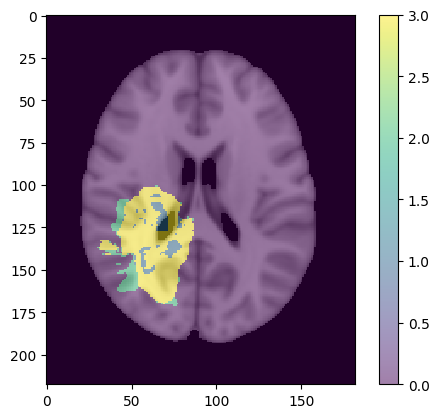

In [8]:
#let's plot one of the tumour segmentastions on the reference atlas
reference_brain = atlases+'MNI152_T1_1mm_brain.nii.gz'
reference_brain = nib.load(reference_brain)
reference_brain_array = np.asanyarray(reference_brain.dataobj)

ndimage.rotate(reference_brain_array[:,:,91], 90)

im1 = plt.imshow(ndimage.rotate(reference_brain_array[:,:,91], 90), cmap=plt.cm.gray, interpolation='nearest')

i=0
tumour = np.asanyarray(nib.load(neurorad_hand_label+neurorad_hand_label_subs[i]+'.nii.gz').dataobj)

im2 = plt.imshow(ndimage.rotate(tumour[:,:,91], 90), interpolation='nearest',alpha=.5,cmap='viridis')
cbar = plt.colorbar()

plt.show()

#on the segmentation, these are the following labels
# enhancing tumour = 3 (yellow bits)
# nonenhancing tumour = 1 (blue bit)
# oedema = 2 (green bit)

In [9]:
col_names = ['filename', 'reporter', 'time_taken_seconds',
           'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
           'F3 Eloquent Brain', 'F4 Enhancement Quality',
           'F5 Proportion Enhancing', 'F6 Proportion nCET',
           'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
           'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
           'F12 Definition of the Enhancing margin',
           'F13 Definition of the non-enhancing tumour margin',
           'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
           'F18 Pial invasion', 'F19 Ependymal Invasion',
           'F20 Cortical involvement', 'F21 Deep WM invasion', 
                 'F22 nCET Crosses Midline', 'F23 CET Crosses midline',
                 'F24 satellites',
           'F25 Calvarial modelling', 'COMMENTS']

new_dataframe_for_modelling_hand_label = pd.DataFrame(columns=col_names)
new_dataframe_for_modelling_hand_label['filename']=neurorad_hand_label+neurorad_hand_label_subs+'.nii.gz'

new_dataframe_for_modelling_tumour_seg = pd.DataFrame(columns=col_names)
new_dataframe_for_modelling_tumour_seg['filename']=model_prediction+neurorad_hand_label_subs+'.nii.gz'

In [29]:
def get_vasari_features(file,verbose=False,enhancing_label=3,nonenhancing_label=1,oedema_label=2,z_dim=-1,cf=1,t_ependymal=7500,t_wm=1,resolution=1,midline_thresh=5,enh_quality_thresh=15,cyst_thresh=50,cortical_thresh=1000,focus_thresh=30000,num_components_bin_thresh=10):
    """
    #Required argument
    file - NIFTI segmentation file with binary lesion labels
    
    #Optional hyperparmeters
    verbose - whether to enable verbose logging, default=False
    enhancing_label - the integer value of enhancing tumour within file, default=3
    nonenhancing_label - the integer value of nonenhancing tumour within file, default=1
    oeedema_label - the integer value of nonenhancing tumour within file, default=2
    z_dim - the dimension of the Z axis within file, default=-1, which assumes MNI template registration
    cf - correction factor for ambiguity in voxel quantification, default=0
    t_ependymal - threshold for lesion involvement within the ependyma, this can be customised depending on the voxel resolution you are operating in, default=7500
    t_wm - threshold for lesion involvement within the wm, this can be customised depending on the voxel resolution you are operating in, default=1
    resolution - volumetric voxel resolution, this is important for derivation of F11 - thickness of enhancing margin, default=1 (1mm x 1mm x 1mm resolution)
    midline_thresh - threshold for number of diseased voxels that can cross the midline to be quantified as a lesion definitively crossing the midline
    enh_quality_thresh - threshold for determining the quality of lesion enhancement by volume approximation. Please note ideally this feature would utilise source imaging but in its prototype format uses anonymised segmentation data only
    cyst_thresh - threshold for determining the presence of cysts based on a heuristic of nCET detection, default=10
    cortical_thresh - threshold for determining cortex involvement, default=1000
    focus_thresh - threshold for determining a side of involvement, this will vary depending on resolution, default=30000
    num_components_bin_thresh - threshold for quantifying a multifocal lesion, default = 10
    """
    
    start_time = time.time()
    
    if verbose:
        print('Please note that this software is in beta and utilises only irrevocably anonymised lesion masks.\nVASARI features that require source data shall not be derived and return NaN')
        print('')
        print('Working on: '+str(file))
        print('')
    
    segmentation = nib.load(file)
    segmentation_array = np.asanyarray(segmentation.dataobj)
    
    if verbose:
        print('Running voxel quantification per tissue class')
    total_lesion_burden = np.count_nonzero(segmentation_array)
    enhancing_voxels = np.count_nonzero(segmentation_array == enhancing_label)
    nonenhancing_voxels = np.count_nonzero(segmentation_array == nonenhancing_label)
    oedema_voxels = np.count_nonzero(segmentation_array == oedema_label)
    
    if verbose:
        print('Deriving number of components')
    labeled_array, num_components = label(segmentation_array)
    
    if verbose:
        print('Determining laterality')
        #print('Note - if experiencing unexpected axis flipping for lesion laterality, check lesion registration space. This code assumes MNI template registration')
    temp = segmentation_array.nonzero()[0]
    right_hemisphere=len(temp[temp<int(segmentation_array.shape[z_dim]/2)])
    left_hemisphere=len(temp[temp>int(segmentation_array.shape[z_dim]/2)])
    if right_hemisphere>left_hemisphere:
        side='Right'
    if right_hemisphere<left_hemisphere:
        side='Left'
    if right_hemisphere>focus_thresh and left_hemisphere>focus_thresh:
        side='Bilateral'
    if verbose:
        print(right_hemisphere)
        print(left_hemisphere)

    if verbose:
        print('Determining proportions')
    segmentation_array[segmentation_array==oedema_label]=0
    segmentation_array[segmentation_array==enhancing_label]=1
    segmentation_array[segmentation_array==nonenhancing_label]=1
    
    if segmentation_array.sum()==0:
        if verbose:
            print('No lesion detected, falling back to oedema label for closer inspection')
        segmentation_array = np.asanyarray(segmentation.dataobj)
        segmentation_array[segmentation_array!=oedema_label]=0

    prop_in_brainstem = len((segmentation_array*brainstem_array).nonzero()[0])/(segmentation_array.sum()+cf)
    prop_in_frontal_lobe = len((segmentation_array*frontal_lobe_array).nonzero()[0])/(segmentation_array.sum()+cf)
    prop_in_insula = len((segmentation_array*insula_array).nonzero()[0])/(segmentation_array.sum()+cf)
    prop_in_occipital = len((segmentation_array*occipital_array).nonzero()[0])/(segmentation_array.sum()+cf)
    prop_in_parietal = len((segmentation_array*parietal_array).nonzero()[0])/(segmentation_array.sum()+cf)
    prop_in_temporal = len((segmentation_array*temporal_array).nonzero()[0])/(segmentation_array.sum()+cf)
    prop_in_thalamus = len((segmentation_array*thalamus_array).nonzero()[0])/(segmentation_array.sum()+cf)
    prop_in_cc = len((segmentation_array*corpus_callosum_array).nonzero()[0])/(segmentation_array.sum()+cf)

    d = {'ROI': ['Brainstem','Frontal Lobe','Insula','Occipital Lobe','Parietal Lobe','Temporal Lobe','Thalamus','Corpus callosum'], 
         'prop': [prop_in_brainstem,prop_in_frontal_lobe,prop_in_insula,prop_in_occipital,prop_in_parietal,prop_in_temporal,prop_in_thalamus,prop_in_cc]}
    
    vols = pd.DataFrame(data=d)
    vols = vols.sort_values(by='prop',ascending=False).reset_index(drop=True)
    
    if verbose:
        print(vols)
    
    proportion_enhancing = (enhancing_voxels/total_lesion_burden)*100
#     proportion_enhancing = (enhancing_voxels/(enhancing_voxels+nonenhancing_voxels+.1))*100
    proportion_nonenhancing = (nonenhancing_voxels/total_lesion_burden)*100
#     proportion_nonenhancing = (nonenhancing_voxels/(enhancing_voxels+nonenhancing_voxels+.1))*100
    proportion_oedema = (oedema_voxels/total_lesion_burden+.1)*100
    
    enhancement_quality = 1
    if proportion_enhancing>0: #heuristic of if model segments more than 10% voxels are enhancing
        if proportion_enhancing>enh_quality_thresh:
            enhancement_quality=3
        else:
            enhancement_quality=2
    
    if verbose:
        print('Determining ependymal involvement')
    if len((segmentation_array*ventricles_array).nonzero()[0])>=t_ependymal:
        ependymal=2

    if len((segmentation_array*ventricles_array).nonzero()[0])<t_ependymal:
        ependymal=1

    if verbose:
        print('Determining white matter involvemenet')
    deep_wm='None'
    if len((segmentation_array*brainstem_array).nonzero()[0])>=t_wm:
        deep_wm='Brainstem'

    if len((segmentation_array*corpus_callosum_array).nonzero()[0])>=t_wm:
        deep_wm='Corpus Callosum'

    if len((segmentation_array*internal_capsule_array).nonzero()[0])>=t_wm:
        deep_wm='Internal Capsule'
    deep_wm_f = np.nan
    if deep_wm=='None':
        deep_wm_f=1
    if deep_wm!='None':
        deep_wm_f=2
        
    if verbose:
        print('Determining cortical involvement')
    cortical_lesioned_voxels = len((segmentation_array*cortex_array).nonzero()[0])
    cortical_lesioned_voxels_f = np.nan
    if cortical_lesioned_voxels>cortical_thresh:
        cortical_lesioned_voxels_f=2
    if cortical_lesioned_voxels<=cortical_thresh:
        cortical_lesioned_voxels_f=1

    if verbose:
        print('Determining midline involvement')
    nCET_cross_midline=False
    nCET = np.asanyarray(segmentation.dataobj)
    nCET[nCET!=nonenhancing_label]=0
    nCET[nCET>0]=1
    temp = nCET.nonzero()[0]
    right_hemisphere=len(temp[temp<int(segmentation_array.shape[z_dim]/2)])
    left_hemisphere=len(temp[temp>int(segmentation_array.shape[z_dim]/2)])
    if right_hemisphere>midline_thresh and left_hemisphere>midline_thresh:
        nCET_cross_midline=True
    nCET_cross_midline_f = np.nan
    if nCET_cross_midline==True:
        nCET_cross_midline_f=3
    if nCET_cross_midline==False:
        nCET_cross_midline_f=2
    
    CET_cross_midline=False
    CET = np.asanyarray(segmentation.dataobj)
    CET[CET!=enhancing_label]=0
    CET[CET>0]=1
    temp = CET.nonzero()[0]
    right_hemisphere=len(temp[temp<int(segmentation_array.shape[z_dim]/2)])
    left_hemisphere=len(temp[temp>int(segmentation_array.shape[z_dim]/2)])
    if right_hemisphere>midline_thresh and left_hemisphere>midline_thresh:
        CET_cross_midline=True
    CET_cross_midline_f = np.nan
    if CET_cross_midline==True:
        CET_cross_midline_f=3
    if CET_cross_midline==False:
        CET_cross_midline_f=2

    if verbose:
        print('Deriving enhancing satellites')
    labeled_array, num_components_cet = label(CET)
    num_components_cet_f = np.nan
    if num_components_cet>0:
        num_components_cet_f =2
    if num_components_cet==0:
        num_components_cet_f=1
    
    if verbose:
        print('Deriving cysts')
    #heuristic to approximate cyst formation by multifocal nonenhancing components
    labeled_array, num_components_ncet = label(nCET)
    num_components_ncet_f =1
    if num_components_ncet>cyst_thresh:
        num_components_ncet_f=2
        
    if verbose:
        print('cysts '+str(num_components_ncet))
        
    if verbose:
        print('Deriving enhancement thickness')
        
    
    enhancing_skeleton = skeletonize(CET)
    allpixels = np.count_nonzero(CET)
    skeletonpixels = np.count_nonzero(enhancing_skeleton)
    
    if allpixels>0:
        enhancing_thickness = allpixels/skeletonpixels
    if allpixels==0:
        enhancing_thickness=0
    enhancing_thickness_f = np.nan
    ll=3
    if enhancing_thickness<ll:
        enhancing_thickness_f=3
    if enhancing_thickness>=ll:
        enhancing_thickness_f=4
    if enhancing_thickness>=ll and nonenhancing_voxels==0:
        enhancing_thickness_f=5
        
    if verbose:
        print('enhancing thickness '+str(enhancing_thickness))
    
    if verbose:
        print('Converting raw values to VASARI dictionary features')
    F1_dict = {'Frontal Lobe':1,'Temporal Lobe':2,'Insula':3,'Parietal Lobe':4,'Occipital Lobe':5,'Brainstem':6,'Corpus callosum':7,'Thalamus':8}
    F2_dict = {'Right':1,'Left':3,'Bilateral':2}

    proportion_enhancing_f = np.nan
    if proportion_enhancing<=5:
        proportion_enhancing_f = 3
    if 5 < proportion_enhancing <= 33:
        proportion_enhancing_f = 4
    if 33 < proportion_enhancing <= 67:
        proportion_enhancing_f = 5
    if 67 < proportion_enhancing <= 100:
        proportion_enhancing_f = 6
        
    proportion_nonenhancing_f = np.nan
    if proportion_nonenhancing<=5:
        proportion_nonenhancing_f = 3
    if 5 < proportion_nonenhancing <= 33:
        proportion_nonenhancing_f = 4
    if 33 < proportion_nonenhancing <= 67:
        proportion_nonenhancing_f = 5
    if 67 < proportion_nonenhancing <= 95:
        proportion_nonenhancing_f = 6  
    if 95 < proportion_nonenhancing <= 99.5:
        proportion_nonenhancing_f = 7
    if proportion_nonenhancing >99.5: #allow for small segmentation variation
        proportion_nonenhancing_f = 8 
        
    proportion_necrosis_f = np.nan
    if proportion_nonenhancing==0:
        proportion_necrosis_f=2
    if 0<proportion_nonenhancing<=5:
        proportion_necrosis_f=3
    if 5<proportion_nonenhancing<=33:
        proportion_necrosis_f=4
    if 33<proportion_nonenhancing<=67:
        proportion_necrosis_f=5
        
    segmentation_array_binary = segmentation_array.copy()
    segmentation_array_binary[segmentation_array_binary>0]=1
    labeled_array_bin, num_components_bin = label(segmentation_array_binary)
    f9_multifocal = 1
    if num_components_bin>num_components_bin_thresh:
        f9_multifocal=2
    if verbose:
        print('num_components_bin: '+str(num_components_bin))
        
    proportion_oedema_f=np.nan
    if proportion_oedema==0:
        proportion_oedema_f=2
    if 0<proportion_oedema<=5:
        proportion_oedema_f=3
    if 5<proportion_oedema<=33:
        proportion_oedema_f=4
    if 33<proportion_oedema<=67:
        proportion_oedema_f=5
    
        
    end_time = time.time()
    if verbose:
        print(f"Time taken for data {i}: {end_time - start_time} seconds")
    time_taken = (end_time - start_time)
        
    if verbose:
        print('')
        print('Complete! Generating output...')
        
    col_names = ['filename', 'reporter', 'time_taken_seconds',
           'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
           'F3 Eloquent Brain', 'F4 Enhancement Quality',
           'F5 Proportion Enhancing', 'F6 Proportion nCET',
           'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
           'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
           'F12 Definition of the Enhancing margin',
           'F13 Definition of the non-enhancing tumour margin',
           'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
           'F18 Pial invasion', 'F19 Ependymal Invasion',
           'F20 Cortical involvement', 'F21 Deep WM invasion', 
                 'F22 nCET Crosses Midline', 'F23 CET Crosses midline',
                 'F24 satellites',
           'F25 Calvarial modelling', 'COMMENTS']
        

    result = pd.DataFrame(columns=col_names)
    result.loc[len(result)] = {'filename':file,
                               'reporter':'VASARI-auto',
                              'time_taken_seconds':time_taken,
                              'F1 Tumour Location':F1_dict[vols.iloc[0,0]], #vols.iloc[0,0],
                              'F2 Side of Tumour Epicenter':F2_dict[side],
                              'F3 Eloquent Brain':np.nan, #to codify with eloquency mask
                              'F4 Enhancement Quality':enhancement_quality,
                              'F5 Proportion Enhancing':proportion_enhancing_f,
                              'F6 Proportion nCET':proportion_nonenhancing_f,
                              'F7 Proportion Necrosis':proportion_necrosis_f,
                              'F8 Cyst(s)':num_components_ncet_f, #unsupported in current version
                                'F9 Multifocal or Multicentric':f9_multifocal,
                               'F10 T1/FLAIR Ratio':np.nan,  #unsupported in current version
                               'F11 Thickness of enhancing margin':enhancing_thickness_f,
                               'F12 Definition of the Enhancing margin':np.nan,  #unsupported in current version
                               'F13 Definition of the non-enhancing tumour margin':np.nan,  #unsupported in current version
                               'F14 Proportion of Oedema': proportion_oedema_f,
                               'F16 haemorrhage':np.nan,  #unsupported in current version
                               'F17 Diffusion':np.nan,  #unsupported in current version
                               'F18 Pial invasion':np.nan, #unsupported in current version
                               'F19 Ependymal Invasion':ependymal, 
                               'F20 Cortical involvement':cortical_lesioned_voxels_f,
                               'F21 Deep WM invasion':deep_wm_f, 
                               'F22 nCET Crosses Midline':nCET_cross_midline_f,
                               'F23 CET Crosses midline':CET_cross_midline_f,
                               'F24 satellites':num_components_cet_f, 
                               'F25 Calvarial modelling':np.nan, #unsupported in current version
                               'COMMENTS':'Please note that this software is in beta and utilises only irrevocably anonymised lesion masks. VASARI features that require source data shall not be derived and return NaN'
                              }
    return result

In [11]:
for i, row in tqdm(new_dataframe_for_modelling_hand_label.iterrows(),total=len(new_dataframe_for_modelling_hand_label)):
    result = get_vasari_features(file=row['filename'])
    new_dataframe_for_modelling_hand_label.iloc[i,:]=result.values[0]

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


In [12]:
for i, row in tqdm(new_dataframe_for_modelling_tumour_seg.iterrows(),total=len(new_dataframe_for_modelling_tumour_seg)):
    result = get_vasari_features(file=row['filename'])
    new_dataframe_for_modelling_tumour_seg.iloc[i,:]=result.values[0]

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:43<00:00,  1.04s/it]


In [33]:
get_vasari_features(file=neurorad_hand_label+'UCSF-PDGM-0032.nii.gz',verbose=True)

Please note that this software is in beta and utilises only irrevocably anonymised lesion masks.
VASARI features that require source data shall not be derived and return NaN

Working on: /Users/jruffle/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/forFAITH/neurorad_hand_label/UCSF-PDGM-0032.nii.gz

Running voxel quantification per tissue class
Deriving number of components
Determining laterality
0
99931
Determining proportions
               ROI      prop
0    Temporal Lobe  0.607562
1   Occipital Lobe  0.229599
2    Parietal Lobe  0.081907
3           Insula  0.011552
4         Thalamus  0.010856
5  Corpus callosum  0.002714
6        Brainstem  0.000116
7     Frontal Lobe  0.000000
Determining ependymal involvement
Determining white matter involvemenet
Determining cortical involvement
Determining midline involvement
Deriving enhancing satellites
Deriving cysts
cysts 33
Deriving enhancement thickness
enhancing thickness 5.358078602620087
Converting raw values to VASARI dict

,filename,reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,F7 Proportion Necrosis,...,F17 Diffusion,F18 Pial invasion,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F22 nCET Crosses Midline,F23 CET Crosses midline,F24 satellites,F25 Calvarial modelling,COMMENTS
0,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,1.300856,2,3,NaN,3,5,4,4,...,NaN,NaN,1,2,2,2,2,2,NaN,Please note that this software is in beta and ...


In [14]:
new_dataframe_for_modelling_hand_label.head()

,filename,reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,F7 Proportion Necrosis,...,F17 Diffusion,F18 Pial invasion,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F22 nCET Crosses Midline,F23 CET Crosses midline,F24 satellites,F25 Calvarial modelling,COMMENTS
0,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,1.448065,2,1,NaN,3,5,4,4,...,NaN,NaN,2,2,2,2,2,2,NaN,Please note that this software is in beta and ...
1,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,1.177118,2,3,NaN,3,4,4,4,...,NaN,NaN,1,2,1,2,2,2,NaN,Please note that this software is in beta and ...
2,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,0.937134,1,3,NaN,2,4,3,3,...,NaN,NaN,1,2,1,2,2,2,NaN,Please note that this software is in beta and ...
3,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,0.990003,2,1,NaN,2,4,4,4,...,NaN,NaN,1,2,1,2,2,2,NaN,Please note that this software is in beta and ...
4,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,0.953591,4,3,NaN,3,5,4,4,...,NaN,NaN,1,2,2,2,2,2,NaN,Please note that this software is in beta and ...


In [15]:
new_dataframe_for_modelling_tumour_seg.head()

,filename,reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,F7 Proportion Necrosis,...,F17 Diffusion,F18 Pial invasion,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F22 nCET Crosses Midline,F23 CET Crosses midline,F24 satellites,F25 Calvarial modelling,COMMENTS
0,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,1.279354,2,1,NaN,3,5,4,4,...,NaN,NaN,2,2,2,2,2,2,NaN,Please note that this software is in beta and ...
1,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,1.046932,2,3,NaN,3,4,4,4,...,NaN,NaN,1,2,1,2,2,2,NaN,Please note that this software is in beta and ...
2,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,0.923053,1,3,NaN,2,4,3,3,...,NaN,NaN,1,2,1,2,2,2,NaN,Please note that this software is in beta and ...
3,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,0.952557,2,1,NaN,2,4,4,4,...,NaN,NaN,1,2,1,2,2,2,NaN,Please note that this software is in beta and ...
4,/Users/jruffle/Library/CloudStorage/OneDrive-U...,VASARI-auto,0.940666,4,3,NaN,3,5,5,5,...,NaN,NaN,1,2,2,2,2,2,NaN,Please note that this software is in beta and ...


In [16]:
df.head()

,filename,OS,reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,...,F14 Proportion of Oedema,F16 haemorrhage,F17 Diffusion,F18 Pial invasion,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F24 satellites,F25 Calvarial modelling,COMMENTS
0,UPENN-GBM-00575_11,153,KPB,460,2,1,3,3.0,6,3,...,4,1,N/a,2,2,2,2,1,NaN,NaN
1,UPENN-GBM-00589_11,26,KPB,366,2,3,3,3.0,5,4,...,4,2,N/a,2,1,2,2,1,NaN,NaN
2,UPENN-GBM-00591_11,59,KPB,423,1,3,4,3.0,4,4,...,4,1,N/a,1,1,2,1,1,NaN,NaN
3,UPENN-GBM-00601_11,435,KPB,383,2,1,3,3.0,4,5,...,5,1,N/a,1,2,2,2,1,NaN,NaN
4,UPENN-GBM-00604_11,234,KPB,430,1,3,4,3.0,6,3,...,3,1,N/a,2,1,2,1,1,NaN,NaN


In [17]:
all_data = pd.concat([df,new_dataframe_for_modelling_hand_label,new_dataframe_for_modelling_tumour_seg]).reset_index(drop=True)
all_data['time_taken_seconds'] = all_data['time_taken_seconds'].astype(float)
all_data['mode']='Consultant\nNeuroradiologist'
all_data.loc[all_data['reporter']=='VASARI-auto','mode']='VASARI-auto'
all_data.loc[all_data['reporter']=='KPB','reporter']='#1'
all_data.loc[all_data['reporter']=='HH','reporter']='#2'
all_data.rename(columns={'reporter':'Reporter'},inplace=True)
all_data['DataOrigin']='HandDrawn'

for i, row in all_data.iterrows():
    if 'model_prediction' in all_data.loc[i,'filename']:
        all_data.loc[i,'DataOrigin']='TumourSeg'
        
    all_data.loc[i,'filename']=all_data.loc[i,'filename'].split('/')[-1]
    all_data.loc[i,'filename']=all_data.loc[i,'filename'].split('.nii.gz')[0]
all_data

,filename,OS,Reporter,time_taken_seconds,F1 Tumour Location,F2 Side of Tumour Epicenter,F3 Eloquent Brain,F4 Enhancement Quality,F5 Proportion Enhancing,F6 Proportion nCET,...,F19 Ependymal Invasion,F20 Cortical involvement,F21 Deep WM invasion,F24 satellites,F25 Calvarial modelling,COMMENTS,F22 nCET Crosses Midline,F23 CET Crosses midline,mode,DataOrigin
0,UPENN-GBM-00575_11,153.0,#1,460.000000,2,1,3,3.0,6,3,...,2,2,2,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn
1,UPENN-GBM-00589_11,26.0,#1,366.000000,2,3,3,3.0,5,4,...,1,2,2,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn
2,UPENN-GBM-00591_11,59.0,#1,423.000000,1,3,4,3.0,4,4,...,1,2,1,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn
3,UPENN-GBM-00601_11,435.0,#1,383.000000,2,1,3,3.0,4,5,...,2,2,2,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn
4,UPENN-GBM-00604_11,234.0,#1,430.000000,1,3,4,3.0,6,3,...,1,2,1,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn
5,UPENN-GBM-00611_11,551.0,#1,409.000000,2,3,3,3.0,6,3,...,2,2,2,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn
6,UCSF-PDGM-0486,232.0,#1,390.000000,2,3,2,2.0,3,7,...,1,2,1,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn
7,UPENN-GBM-00159_11,264.0,#1,473.000000,2,3,2024-03-02 00:00:00,3.0,5,5,...,2,2,2,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn
8,UPENN-GBM-00054_11,412.0,#1,490.000000,1,2,1,3.0,5,4,...,2,1,2,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn
9,UCSF-PDGM-0243,1850.0,#1,395.000000,1,3,1,2.0,3,7,...,1,2,1,1,NaN,NaN,NaN,NaN,Consultant\nNeuroradiologist,HandDrawn


In [18]:
all_data.columns

Index(['filename', 'OS', 'Reporter', 'time_taken_seconds',
       'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
       'F3 Eloquent Brain', 'F4 Enhancement Quality',
       'F5 Proportion Enhancing', 'F6 Proportion nCET',
       'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
       'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
       'F12 Definition of the Enhancing margin',
       'F13 Definition of the non-enhancing tumour margin',
       'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
       'F18 Pial invasion', 'F19 Ependymal Invasion',
       'F20 Cortical involvement', 'F21 Deep WM invasion', 'F24 satellites',
       'F25 Calvarial modelling', 'COMMENTS', 'F22 nCET Crosses Midline',
       'F23 CET Crosses midline', 'mode', 'DataOrigin'],
      dtype='object')

In [19]:
def get_ytrue_ypred(df=all_data):
    y_true = df.loc[df['mode']=='Consultant\nNeuroradiologist']
    y_pred = df.loc[df['mode']=='VASARI-auto']
    
    y_true = y_true.drop_duplicates(subset='filename').sort_values(by='filename').reset_index(drop=True)
    y_pred = y_pred.drop_duplicates(subset='filename').sort_values(by='filename').reset_index(drop=True)
    
    if list(y_true['filename']) != list(y_pred['filename']):
        print('MISMATCH!')
    
    return y_true, y_pred

0.6781609195402298


Text(0.5, 1.0, 'F11 Thickness of enhancing margin')

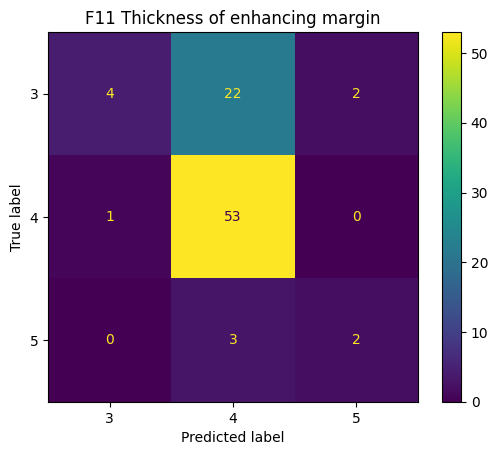

In [20]:
y_true, y_pred = get_ytrue_ypred()
vasari_metric='F11 Thickness of enhancing margin'

print(accuracy_score(y_true=y_true[vasari_metric].values.astype(int),y_pred=y_pred[vasari_metric].values.astype(int)))

cm = confusion_matrix(y_true[vasari_metric].values.astype(int), y_pred=y_pred[vasari_metric].values.astype(int),labels=np.unique(y_true[vasari_metric].values.astype(int)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y_true[vasari_metric].values.astype(int)))
disp.plot()
plt.title(vasari_metric)

In [21]:
# UPENN-GBM-00157_11
# if bilateral state so

# UPENN-GBM-00164_11 should be corpus callosum and bilatearl
# UPENN-GBM-00325_11 should be bilateral and brainstem, not thalamus
# UPENN-GBM-00405_11 should be corpus callosum and bilatearl
# UPENN-GBM-00407_11 should be corpus callosum and bilatearl
# UCSF-PDGM-0232 all segmented as oedema not NET

In [22]:
y_pred.columns

Index(['filename', 'OS', 'Reporter', 'time_taken_seconds',
       'F1 Tumour Location', 'F2 Side of Tumour Epicenter',
       'F3 Eloquent Brain', 'F4 Enhancement Quality',
       'F5 Proportion Enhancing', 'F6 Proportion nCET',
       'F7 Proportion Necrosis', 'F8 Cyst(s)', 'F9 Multifocal or Multicentric',
       'F10 T1/FLAIR Ratio', 'F11 Thickness of enhancing margin',
       'F12 Definition of the Enhancing margin',
       'F13 Definition of the non-enhancing tumour margin',
       'F14 Proportion of Oedema', 'F16 haemorrhage', 'F17 Diffusion',
       'F18 Pial invasion', 'F19 Ependymal Invasion',
       'F20 Cortical involvement', 'F21 Deep WM invasion', 'F24 satellites',
       'F25 Calvarial modelling', 'COMMENTS', 'F22 nCET Crosses Midline',
       'F23 CET Crosses midline', 'mode', 'DataOrigin'],
      dtype='object')

In [30]:
print(*(p for p,v in enumerate(zip(list(y_pred[vasari_metric]),list(y_true[vasari_metric]))) if v[0]^v[1]))

3 7 8 9 10 11 17 18 22 24 29 30 31 33 34 39 42 47 55 61 66 67 68 79 82 83 84 86


In [31]:
index = 3

In [34]:
y_true.iloc[index,:]

filename                                                           UCSF-PDGM-0032
OS                                                                          105.0
Reporter                                                                       #1
time_taken_seconds                                                          476.0
F1 Tumour Location                                                              2
F2 Side of Tumour Epicenter                                                     3
F3 Eloquent Brain                                                               3
F4 Enhancement Quality                                                        3.0
F5 Proportion Enhancing                                                         6
F6 Proportion nCET                                                              3
F7 Proportion Necrosis                                                          5
F8 Cyst(s)                                                                      1
F9 Multifocal or

In [35]:
y_pred.iloc[index,:]

filename                                                                                UCSF-PDGM-0032
OS                                                                                                 NaN
Reporter                                                                                   VASARI-auto
time_taken_seconds                                                                            1.225031
F1 Tumour Location                                                                                   2
F2 Side of Tumour Epicenter                                                                          3
F3 Eloquent Brain                                                                                  NaN
F4 Enhancement Quality                                                                               3
F5 Proportion Enhancing                                                                              5
F6 Proportion nCET                                                       

In [27]:
tt = stats.ttest_ind(all_data.loc[all_data[x]=='Consultant\nNeuroradiologist',y].values,all_data.loc[all_data[x]=='VASARI-auto',y].values)
print(tt.pvalue)

plt.figure(figsize=(3.5,5))
x='mode'
y='time_taken_seconds'
ax = sns.boxplot(data=all_data,x=x,y=y,dodge=True,saturation=0.1,fill=False,color='k',fliersize=0,legend=None,linewidth=.5,width=.5)
ax = sns.swarmplot(data=all_data,x=x,y=y,hue='Reporter',dodge=False,size=3,alpha=.7)

# annot = Annotator(ax,[('Consultant\nNeuroradiologist','VASARI-auto')],data=all_data,x=x,y=y)
# annot.configure(text_format='star',log='outside',verbose=2)
# annot.apply_test()

#asplit=True,gap=.1,inner='quart',dodge=True
ax.set(xlabel='Labeller')
ax.set(ylabel='Time taken (s)')
ax.set_yscale('log')
ticks = [0.5,1,2,4,8,16,32,64,128,256,512,1024]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)
# ax,test_results = annot.annotate()
# ax.legend(bbox_to_anchor=(1,1))
plt.savefig(figures_out+"efficiency.png",dpi=150,bbox_inches='tight')

NameError: name 'x' is not defined